=== STEP 1. SETUP AND IMPORTS ===

In [1]:
# Always pull the latest repo to ensure consistency
!rm -rf Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update
!git clone https://github.com/trongjhuongwr/Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update.git
%cd Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update

Cloning into 'Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 223 (delta 113), reused 169 (delta 62), pack-reused 0 (from 0)
Receiving objects: 100% (223/223), 737.05 KiB | 11.89 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/kaggle/working/Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import random
import os
import json
import sys
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import time

# Ensure repo code is importable
sys.path.append(os.path.abspath(os.getcwd()))

from dataloader.meta_dataloader import SignatureEpisodeDataset
from models.feature_extractor import ResNetFeatureExtractor
from models.meta_learner import MetricGenerator
from utils.model_evaluation import evaluate_meta_model, plot_roc_curve, plot_confusion_matrix, plot_far_frr_eer
from utils.helpers import MemoryTracker

print("Setup and Imports successful!")

Setup and Imports successful!


=== STEP 2. CONFIGURATION ===

In [3]:
# Meta-Learning Parameters for Evaluation
K_SHOT = 10
N_QUERY_GENUINE = 14
N_QUERY_FORGERY = 14

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Paths (adjust to your environment)
BEST_CEDAR_MODEL_DIR = '/kaggle/input/best-cedar-model-weights/best_model_fold_5'
BHSIG_RAW_BASE_DIR = '/kaggle/input/bhsig260-hindi-bengali'  # folder containing 'Bengali' and 'Hindi'
SPLIT_OUTPUT_DIR = '/kaggle/working/'
BENGALI_SPLIT_FILE = os.path.join(SPLIT_OUTPUT_DIR, 'bhsig_bengali_meta_test.json')
HINDI_SPLIT_FILE = os.path.join(SPLIT_OUTPUT_DIR, 'bhsig_hindi_meta_test.json')

SEED = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(SEED)
print(f"Seed set to {SEED}")

print(f"Best CEDAR model path: {BEST_CEDAR_MODEL_DIR}")
print(f"BHSig-260 raw data path: {BHSIG_RAW_BASE_DIR}")
print(f"Bengali split file will be at: {BENGALI_SPLIT_FILE}")
print(f"Hindi split file will be at: {HINDI_SPLIT_FILE}")

# Workers
NUM_WORKERS = os.cpu_count() // 2 if 'kaggle' in os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '') else 0
print(f"Using {NUM_WORKERS} data loader workers.")

Using device: cuda
Seed set to 42
Best CEDAR model path: /kaggle/input/best-cedar-model-weights/best_model_fold_5
BHSig-260 raw data path: /kaggle/input/bhsig260-hindi-bengali
Bengali split file will be at: /kaggle/working/bhsig_bengali_meta_test.json
Hindi split file will be at: /kaggle/working/bhsig_hindi_meta_test.json
Using 0 data loader workers.


=== STEP 3. PREPARE BHSIG-260 SPLIT FILE ===

In [4]:
script_path = 'scripts/restructure_bhsig.py'

# Choose how many test users to extract per language
NUM_BENGALI_TEST = 100
NUM_HINDI_TEST = 160

command = (
    f"python {script_path} "
    f"--base_dir {BHSIG_RAW_BASE_DIR} "
    f"--output_dir {SPLIT_OUTPUT_DIR} "
    f"--seed {SEED} "
    f"--num_bengali {NUM_BENGALI_TEST} "
    f"--num_hindi {NUM_HINDI_TEST}"
)

print(f"Running command: {command}")
!{command}

# Verify outputs
if not os.path.exists(BENGALI_SPLIT_FILE):
    print(f"Error: Bengali split file not found at {BENGALI_SPLIT_FILE}.")
    raise FileNotFoundError("Bengali split file creation failed.")
if not os.path.exists(HINDI_SPLIT_FILE):
    print(f"Error: Hindi split file not found at {HINDI_SPLIT_FILE}.")
    raise FileNotFoundError("Hindi split file creation failed.")

print("BHSig-260 Bengali and Hindi split files generated successfully.")

Running command: python scripts/restructure_bhsig.py --base_dir /kaggle/input/bhsig260-hindi-bengali --output_dir /kaggle/working/ --seed 42 --num_bengali 100 --num_hindi 160
--- Starting BHSig-260 (nth2165) Dataset Restructuring ---
Scanning source directories...
  Processing: /kaggle/input/bhsig260-hindi-bengali/BHSig160_Hindi/Genuine
  Processing: /kaggle/input/bhsig260-hindi-bengali/BHSig160_Hindi/Forged
  Processing: /kaggle/input/bhsig260-hindi-bengali/BHSig100_Bengali/Genuine
  Processing: /kaggle/input/bhsig260-hindi-bengali/BHSig100_Bengali/Forged
Finished scanning. Processed 14040 files, skipped 0.
Found data for 260 unique users (Bengali + Hindi).
  Available Bengali users: 100
  Available Hindi users: 160
Selected 100 Bengali users for Bengali test split.
Selected 160 Hindi users for Hindi test split.
  Successfully saved Bengali meta-test split to: /kaggle/working/bhsig_bengali_meta_test.json
  Successfully saved Hindi meta-test split to: /kaggle/working/bhsig_hindi_meta_t

=== STEP 4. LOAD THE BEST MODEL TRAINED ON CEDAR ===

In [5]:
print(f"--- Loading the best model trained on CEDAR from {BEST_CEDAR_MODEL_DIR} ---")

OUTPUT_DIM = 512  # must match training
feature_extractor = ResNetFeatureExtractor(backbone_name='resnet34', output_dim=OUTPUT_DIM)
metric_generator = MetricGenerator(embedding_dim=OUTPUT_DIM)

fe_path = os.path.join(BEST_CEDAR_MODEL_DIR, 'best_feature_extractor.pth')
mg_path = os.path.join(BEST_CEDAR_MODEL_DIR, 'best_metric_generator.pth')

load_success = True
try:
    if not os.path.exists(fe_path):
        raise FileNotFoundError(f"Feature extractor weights not found: {fe_path}")
    if not os.path.exists(mg_path):
        raise FileNotFoundError(f"Metric generator weights not found: {mg_path}")

    feature_extractor.load_state_dict(torch.load(fe_path, map_location=DEVICE))
    metric_generator.load_state_dict(torch.load(mg_path, map_location=DEVICE))

    feature_extractor.to(DEVICE)
    metric_generator.to(DEVICE)

    feature_extractor.eval()
    metric_generator.eval()

    print("Successfully loaded model weights trained on CEDAR!")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the BEST_CEDAR_MODEL_DIR path is correct and the dataset is added.")
    load_success = False
except Exception as e:
    print(f"An unexpected error occurred while loading model weights: {e}")
    load_success = False

if not load_success:
    raise RuntimeError("Failed to load model weights. Cannot proceed with evaluation.")

--- Loading the best model trained on CEDAR from /kaggle/input/best-cedar-model-weights/best_model_fold_5 ---


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 180MB/s]


Initialized MetricGenerator with Attention. Embedding dim: 512, Hidden dim: 1024, Dropout: 0.3.
Successfully loaded model weights trained on CEDAR!


=== STEP 5. DEFINE EVALUATION HELPER FUNCTION ===

In [6]:
def run_evaluation(language_name, split_file, base_dir_ignored=None):
    """Runs evaluation on a specific language dataset and prints/plots results."""
    print(f"\n--- Creating evaluation dataset for BHSig-260 ({language_name}) ---")

    eval_transform = transforms.Compose([
        transforms.Resize((220, 150)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    try:
        test_dataset = SignatureEpisodeDataset(
            split_file_path=split_file,
            base_data_dir=None,      # not needed when use_full_path=True
            split_name='meta-test',
            k_shot=K_SHOT,
            n_query_genuine=N_QUERY_GENUINE,
            n_query_forgery=N_QUERY_FORGERY,
            augment=False,
            use_full_path=True
        )
        print(f"Successfully created {language_name} evaluation dataset with {len(test_dataset)} episodes.")
    except Exception as e:
        print(f"Error creating {language_name} dataset: {e}")
        return None

    print(f"\n--- Starting Cross-Dataset Evaluation on BHSig-260 ({language_name}) --- ({len(test_dataset)} users) ---")
    eval_start_time = time.time()

    # (optional) memory tracking
    mem_tracker = None
    if DEVICE.type == 'cuda':
        try:
            mem_tracker = MemoryTracker(DEVICE)
            initial_mem = mem_tracker.get_used_memory_mb()
        except Exception:
            mem_tracker = None
            initial_mem = None
    else:
        initial_mem = None

    # Evaluate
    results_dict, true_labels, predictions, distances = evaluate_meta_model(
        feature_extractor,
        metric_generator,
        test_dataset,
        DEVICE
    )

    eval_duration = time.time() - eval_start_time
    print(f"--- {language_name} Evaluation Finished (Duration: {eval_duration:.2f}s) ---")

    print(f"\n--- CROSS-DATASET EVALUATION RESULTS (CEDAR -> BHSig-260 {language_name}) ---")
    if results_dict:
        print("Overall Performance Metrics:")
        for metric, value in results_dict.items():
            if metric == 'accuracy':
                 print(f"  - {metric.capitalize()}: {value*100:.2f}%")
            elif metric == 'eer_threshold': # Don't print std for threshold
                 print(f"  - EER Threshold: {value:.4f}")
            else: # Precision, Recall, F1, AUC, EER
                 print(f"  - {metric.replace('_',' ').capitalize()}: {value:.4f}") # Format EER correctly
    else:
        print("Evaluation failed to produce results.")
        return None

    # --- Visualize Results ---
    if true_labels and predictions and distances:
        print("\nVisualizations:")
        plot_title_prefix = f"Cross-Dataset (CEDAR -> BHSig-260 {language_name})"
        plot_roc_curve(true_labels, distances, title=f'{plot_title_prefix} - ROC Curve')
        plot_confusion_matrix(true_labels, predictions, title=f'{plot_title_prefix} - Confusion Matrix')
        # *** ADD THIS PLOT CALL ***
        plot_far_frr_eer(true_labels, distances, title=f'{plot_title_prefix} - FAR/FRR Curve')
    else:
        print("\nSkipping visualizations due to lack of valid evaluation data.")

    # Memory report
    if mem_tracker:
        try:
            final_mem = mem_tracker.get_used_memory_mb()
            print(f"\nInitial GPU Mem: {initial_mem:.2f} MB")
            print(f"Final GPU Mem: {final_mem:.2f} MB")
            print(f"≈ Used During Eval: {final_mem - initial_mem:.2f} MB")
        except Exception:
            pass
        del mem_tracker

    print("---------------------------------------------------------------------")
    return results_dict

=== STEP 6. RUN EVALUATION FOR BENGALI ===


--- Creating evaluation dataset for BHSig-260 (Bengali) ---
Initialized SignatureEpisodeDataset for 'meta-test' split.
  Number of users/episodes: 100
  k_shot: 10, n_query_genuine: 14, n_query_forgery: 14
  Augmentation: Disabled
  Using full paths: True
Successfully created Bengali evaluation dataset with 100 episodes.

--- Starting Cross-Dataset Evaluation on BHSig-260 (Bengali) --- (100 users) ---
MemoryTracker initialized for device cuda:0. Initial used memory: 1502.88 MB


Meta-Testing:   0%|          | 0/100 [00:00<?, ?it/s]

--- Bengali Evaluation Finished (Duration: 33.66s) ---

--- CROSS-DATASET EVALUATION RESULTS (CEDAR -> BHSig-260 Bengali) ---
Overall Performance Metrics:
  - Accuracy: 79.75%
  - Precision: 0.7793
  - Recall: 0.8300
  - F1 score: 0.8039
  - Roc auc: 0.7565
  - Eer: 0.2936
  - EER Threshold: 30.6028

Visualizations:


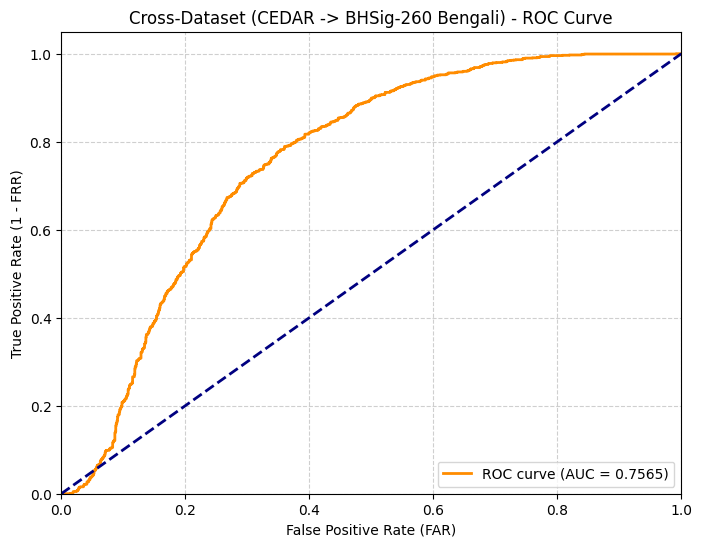

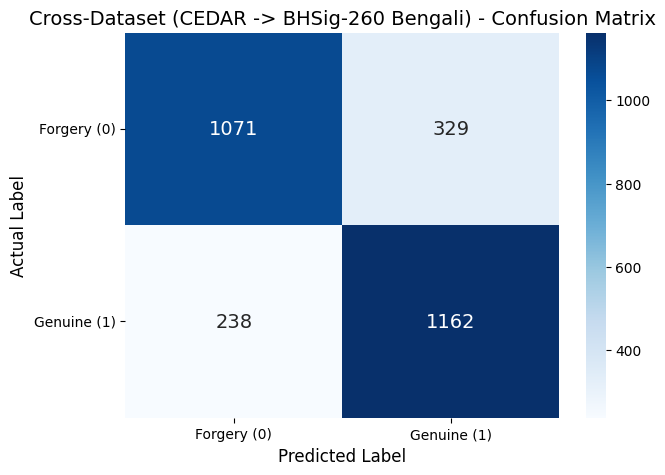

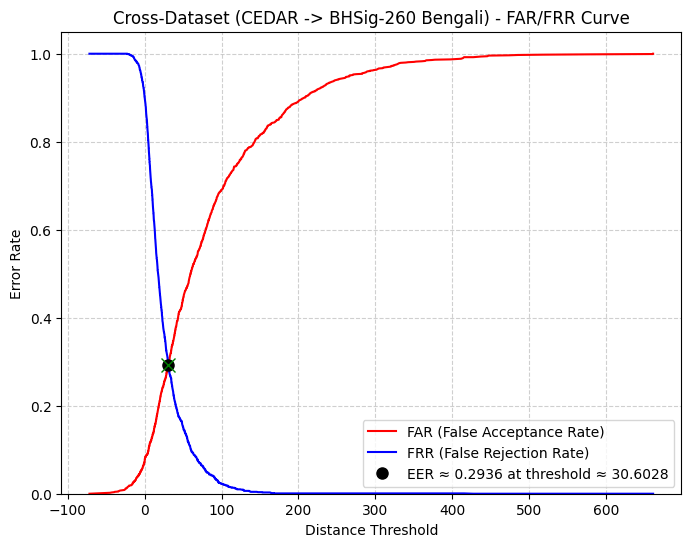


Initial GPU Mem: 1502.88 MB
Final GPU Mem: 1800.88 MB
≈ Used During Eval: 298.00 MB
---------------------------------------------------------------------


In [7]:
bengali_results = run_evaluation("Bengali", BENGALI_SPLIT_FILE)

=== STEP 7. RUN EVALUATION FOR HINDI ===


--- Creating evaluation dataset for BHSig-260 (Hindi) ---
Initialized SignatureEpisodeDataset for 'meta-test' split.
  Number of users/episodes: 160
  k_shot: 10, n_query_genuine: 14, n_query_forgery: 14
  Augmentation: Disabled
  Using full paths: True
Successfully created Hindi evaluation dataset with 160 episodes.

--- Starting Cross-Dataset Evaluation on BHSig-260 (Hindi) --- (160 users) ---
MemoryTracker initialized for device cuda:0. Initial used memory: 1800.88 MB


Meta-Testing:   0%|          | 0/160 [00:00<?, ?it/s]

--- Hindi Evaluation Finished (Duration: 51.72s) ---

--- CROSS-DATASET EVALUATION RESULTS (CEDAR -> BHSig-260 Hindi) ---
Overall Performance Metrics:
  - Accuracy: 74.11%
  - Precision: 0.7121
  - Recall: 0.8094
  - F1 score: 0.7576
  - Roc auc: 0.6930
  - Eer: 0.3415
  - EER Threshold: 23.3820

Visualizations:


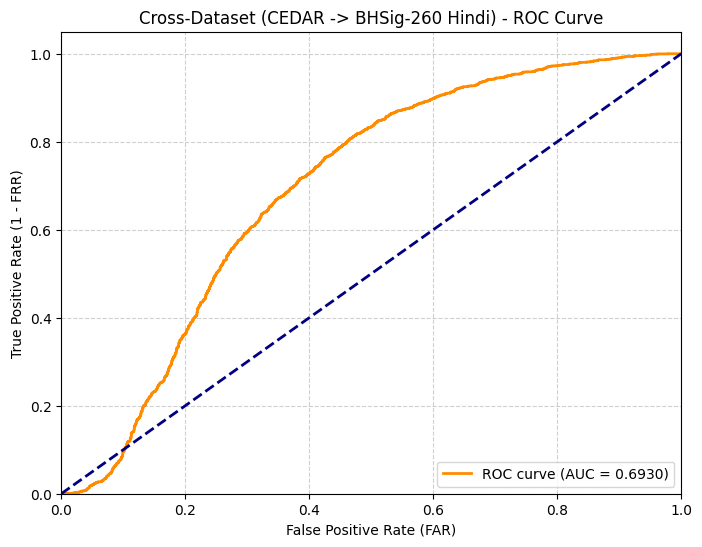

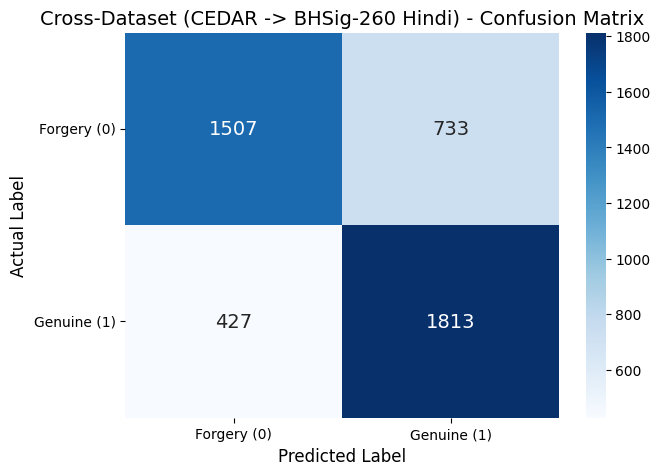

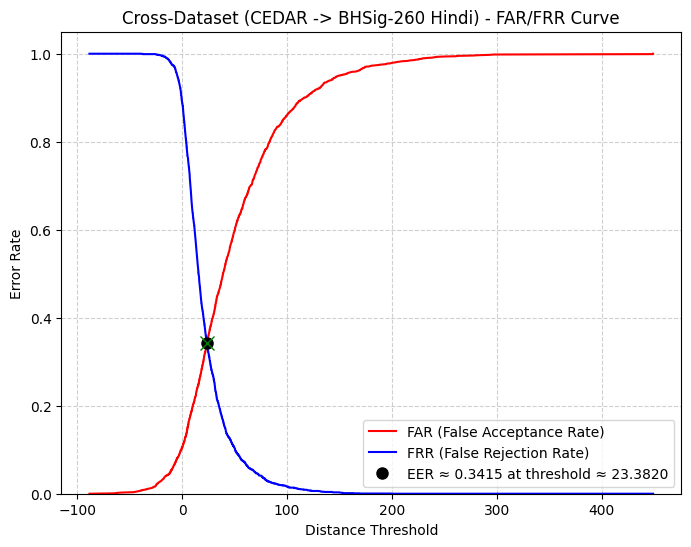


Initial GPU Mem: 1800.88 MB
Final GPU Mem: 1800.88 MB
≈ Used During Eval: 0.00 MB
---------------------------------------------------------------------


In [8]:
hindi_results = run_evaluation("Hindi", HINDI_SPLIT_FILE)

=== STEP 8. SUMMARY AND FINAL MEMORY USAGE ===

In [9]:
print("\n\n=== FINAL SUMMARY ===")
if bengali_results:
    print("\nBengali Evaluation Summary:")
    print(pd.Series(bengali_results).to_string())
else:
    print("\nNo Bengali results to display.")

if hindi_results:
    print("\nHindi Evaluation Summary:")
    print(pd.Series(hindi_results).to_string())
else:
    print("\nNo Hindi results to display.")

print("\n=====================")




=== FINAL SUMMARY ===

Bengali Evaluation Summary:
accuracy          0.797500
precision         0.779343
recall            0.830000
f1_score          0.803874
roc_auc           0.756464
eer               0.293571
eer_threshold    30.602779

Hindi Evaluation Summary:
accuracy          0.741071
precision         0.712097
recall            0.809375
f1_score          0.757626
roc_auc           0.692956
eer               0.341518
eer_threshold    23.382046

